In [99]:
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

pg_connection = psycopg2.connect(
    database="fubon", 
    user="postgres", 
    password="postgres", 
    host="192.168.1.107", 
    port="5432"
)

with pg_connection.cursor() as cursor:
    cursor.execute(query=
        """
            SELECT 
                symbol, 
                date, 
                open, 
                close, 
                low, 
                high, 
                volume
            FROM public.ticker_daily_trading_histories
            ORDER BY date
        """
    )
    
    df = pd.DataFrame(
        cursor.fetchall(),
        columns = ['symbol', 'date', 'open', 'close', 'low', 'high', 'volume']
    )
    # print(df)

# print(df.columns)
# print(df.values)

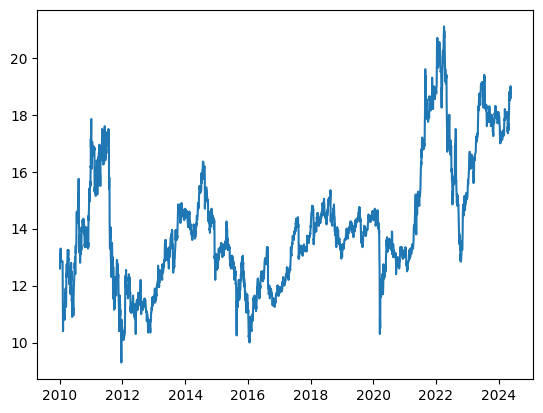

In [100]:
# Function to plot 
plt.plot(
    df['date'].values, 
    df['close'].values
) 

# function to show the plot 
plt.show()

In [101]:
def min_max_normalize(dimension):
    #調整維度成[[資料1],[資料2]]
    dimension = dimension.reshape(-1, 1)
    #正規化數值
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(dimension)
    sc = scaler.transform(dimension)
    
    #[維度還原]
    return sc.reshape(-1)

normalized_open  = min_max_normalize(df['open'].values)
normalized_close = min_max_normalize(df['close'].values)
normalized_low = min_max_normalize(df['low'].values)
normalized_high = min_max_normalize(df['high'].values)
normalized_volume = min_max_normalize(df['volume'].values)

In [110]:
n_days = 3
data = []
labels = []

for i in range(n_days, len(normalized_volume)):
    normalized_open_n_days = normalized_open[i-n_days:i]
    normalized_close_n_days = normalized_close[i-n_days:i]
    normalized_low_n_days = normalized_low[i-n_days:i]
    normalized_high_n_days = normalized_high[i-n_days:i]
    normalized_volume_n_days = normalized_volume[i-n_days:i]
    
    # print(normalized_open_n_days)

    data_n_days = []

    for open, close, low, high, volume in zip(
        normalized_open_n_days,
        normalized_close_n_days,
        normalized_low_n_days,
        normalized_high_n_days,
        normalized_volume_n_days
    ):
        data_n_days.append([open, close, low, high, volume])

    data.append(data_n_days)
    data_n_days = []
    
    labels.append(normalized_close[i:i+1][0])

In [111]:
split_cnt = int(len(data)*0.8)
x_train,y_train = np.array(data[:split_cnt]),np.array(labels[:split_cnt])
x_test,y_test = np.array(data[split_cnt:]),np.array(labels[split_cnt:])

In [116]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,input_shape=(n_days, 5),return_sequences=True,activation='relu'),
    tf.keras.layers.LSTM(64,return_sequences=False,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train, 
    y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/20


/home/vscode/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0800 - val_loss: 0.0194
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.7324e-04 - val_loss: 0.0030
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0378e-04 - val_loss: 0.0033
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.0859e-04 - val_loss: 0.0026
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4458e-04 - val_loss: 0.0017
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6329e-04 - val_loss: 0.0016
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6862e-04 - val_loss: 0.0016
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.4057e-04 - val_loss: 0.0015
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1005e-04 - val_loss: 0.0011
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8871e-04 - val_loss: 0.0014
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


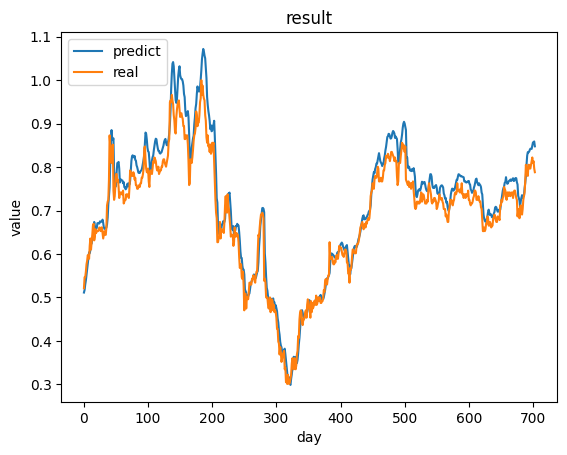

In [117]:
y_predicted = model.predict(x_test)
#預測
plt.plot(y_predicted)
#實際值
plt.plot(y_test)
#標題
plt.title('result')
#y軸標籤
plt.ylabel('value')
#x軸標籤
plt.xlabel('day')
#顯示折線的名稱
plt.legend(['predict', 'real'], loc='upper left')
#顯示折線圖
plt.show()

In [118]:
normalized_close_reshape = df['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(normalized_close_reshape)
actual_close = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
predicted_close = scaler.inverse_transform(y_predicted).reshape(-1)

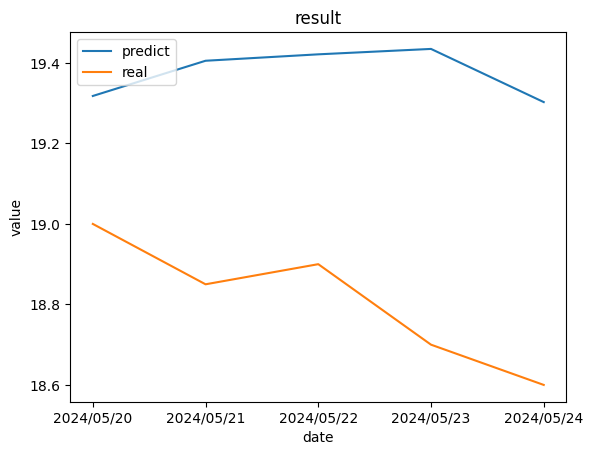

In [120]:
scale_x = [date.strftime("%Y/%m/%d") for date in df[len(df)-5:]['date'].values]
#預測
plt.plot(
    scale_x,
    predicted_close[len(predicted_close)-5:]
)
#實際值
plt.plot(
    scale_x,
    actual_close[len(actual_close)-5:]
)
#標題
plt.title('result')
#y軸標籤
plt.ylabel('value')
#x軸標籤
plt.xlabel('date')
#顯示折線的名稱
plt.legend(['predict', 'real'], loc='upper left')
#顯示折線圖
plt.show()